## ECoG data of faces/houses (+ noise)

Data Source: Miller ECoG dataset from Neuromatch academy



What is ECoG?

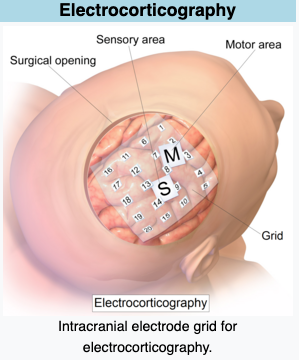

Source:
https://en.wikipedia.org/wiki/Electrocorticography#:~:text=Electrocorticography%20(ECoG)%2C%20a%20type,activity%20from%20the%20cerebral%20cortex.

In [23]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install --user scipy==1.12.0

from matplotlib import rcParams
from matplotlib import pyplot as plt


In [1]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

Journal Source: https://journals.physiology.org/doi/full/10.1152/jn.00113.2017

Subjects: 7 epileptic patients (4 men, 3 women)

Two sessions dat1 and dat2

Subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (dat1). Then in the second experiment in the same subjects (dat2), noise is added to face and houses images and the subject has to detect the faces by pressing a key.

Sample rate: 1000Hz

Experiment 1:

dat1['V']: continuous voltage data (time by channels)

dat1['srate']: acquisition rate (1000 Hz). All stimulus times are in units of this.

dat1['t_on']: time of stimulus onset in data samples

dat1['t_off']: time of stimulus offset, always 400 samples after t_on

dat1['stim_id]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces

dat1['locs]: 3D electrode positions on the brain surface

Experiment 2:

dat2['V]: continuous voltage data (time by channels)

dat2['srate']: acquisition rate (1000 Hz). All stimulus times are in units of this.

dat2['t_on']: time of stimulus onset in data samples

dat2['t_off']: time of stimulus offset, always 1000 samples after t_on, with no inter-stimulus interval

dat2['stim_id]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)

dat2['stim_cat']: stimulus category (1 = house, 2 = face)

dat2['stim_noise']: percent noise from 0 to 100

dat2['key_press']: when the subject thought the image was a face

dat2['categories']: categories legend (1 = house, 2 = face)

dat2['locs]: 3D electrode positions on the brain surface

In [234]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

#alldat.shape (7, 2)

# select just one of the recordings here.
dat1 = alldat[1][0]
dat2 = alldat[1][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [148]:
# @title  3D electrode positions on the brain surface

from nilearn import plotting
from nimare import utils

# https://nilearn.github.io/stable/modules/generated/nilearn.plotting.view_markers.html

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='green',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [150]:
# quick way to get broadband power in time-varying windows
from scipy import signal

def get_broadband_power(dat1):

  V = dat1['V'].astype('float32')

  b, a = signal.butter(3, [50], btype='high', fs=1000)
  V = signal.filtfilt(b, a, V, 0)
  V = np.abs(V)**2

  b, a = signal.butter(3, [10], btype='low', fs=1000)
  V = signal.filtfilt(b, a, V, 0)

  V = V/V.mean(0)

  return V

In [162]:
# @title Separate data for faces and houses

def get_epoch_data(dat1):
  voltage_data=get_broadband_power(dat1)  #=dat1['V'] #(271360, 50)
  t_stamps,nchan=dat1['V'].shape
  nstim=dat1['t_on'].shape[0]
  ephoch_time_range=dat1['t_off'][0]-dat1['t_on'][0]+400

  V_epochs=np.zeros((nstim,ephoch_time_range,nchan))
  for stim_num in range(nstim):
      V_epochs[stim_num,:,:]=voltage_data[dat1['t_on'][stim_num]:dat1['t_off'][stim_num]+400,:]

  return V_epochs

V_epochs=get_epoch_data(dat1)

V_ephocs_house=V_epochs[dat1['stim_id']<=50,:,:]
V_ephocs_faces=V_epochs[dat1['stim_id']>=51,:,:]

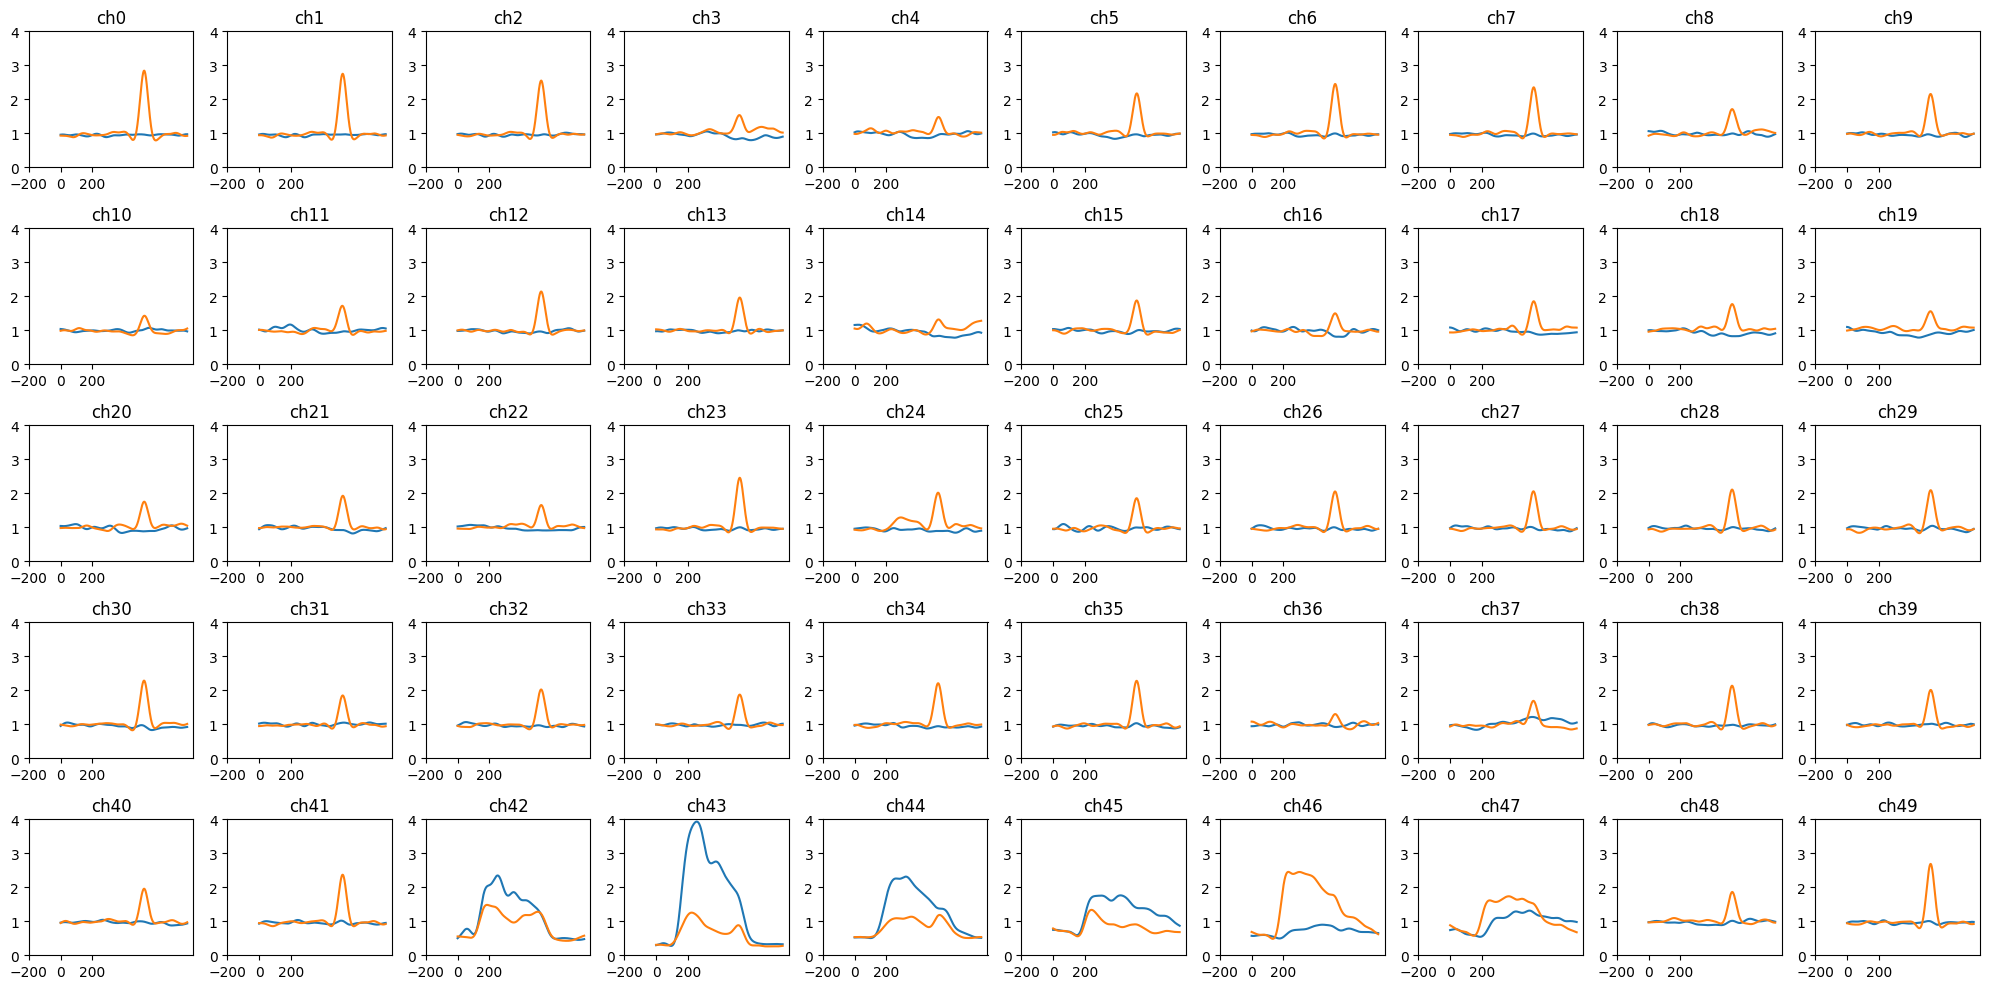

In [163]:
# let's find the electrodes that distinguish faces from houses
plt.figure(figsize=(20, 10))
for j in range(50):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(V_ephocs_house.mean(0)[:, j])
  plt.plot(V_ephocs_faces.mean(0)[:, j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
plt.tight_layout()
plt.show()

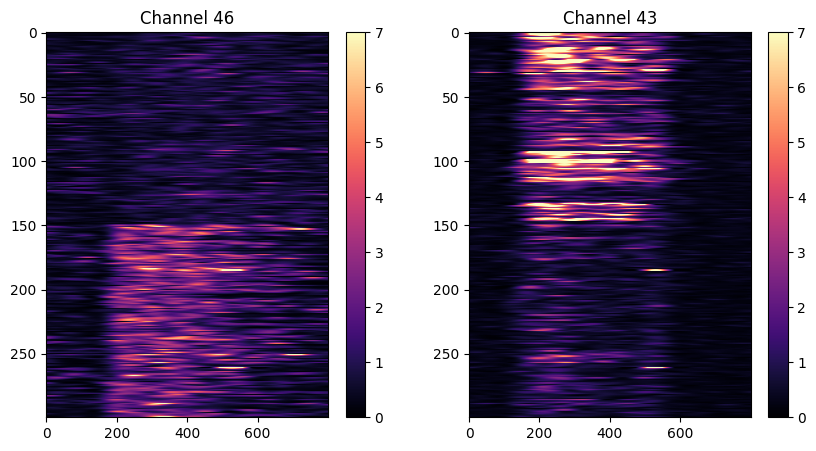

In [157]:
#electrode 46 that has a good response to faces
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 46].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.title('Channel 46')
plt.colorbar()

#electrode 43 that has a good response to houses
ax = plt.subplot(1, 2, 2)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 43].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.title('Channel 43')
plt.colorbar()
plt.show()

In [144]:
# @title Selectivity index

# comparing response magnitude and response latency

# return face_selectivity_index and face response latency (face_selectivity_index>1: face selective; face_selectivity_index>1: house selective)

def face_selectivity_index(dat1,ch_id):

  V_ephocs_house=V_epochs[dat1['stim_id']<=50,:,ch_id].mean(0)
  V_ephocs_faces=V_epochs[dat1['stim_id']>=51,:,ch_id].mean(0)

  return max(V_ephocs_faces)/max(V_ephocs_house), np.argmax(V_ephocs_faces)


In [164]:
# eg. channel 43 and 46

face_selectivity_index(dat1,46), face_selectivity_index(dat1,43)

((2.7262821923526874, 232), (0.3191386390992364, 224))

### Noisy data

In [204]:
# extract data at different noise levels

V_epochs_noise=get_epoch_data(dat2)

V_ephocs_house_noise_25=V_epochs_noise[np.squeeze(dat2['stim_cat']==1) & np.squeeze(dat2['stim_noise']<=25) ,:,:]
V_ephocs_faces_noise_25=V_epochs_noise[np.squeeze(dat2['stim_cat']==2) & np.squeeze(dat2['stim_noise']<=25),:,:]

V_ephocs_house_noise_50=V_epochs_noise[np.squeeze(dat2['stim_cat']==1) & np.squeeze(dat2['stim_noise']>25) & np.squeeze(dat2['stim_noise']<=50) ,:,:]
V_ephocs_faces_noise_50=V_epochs_noise[np.squeeze(dat2['stim_cat']==2) & np.squeeze(dat2['stim_noise']>25) & np.squeeze(dat2['stim_noise']<=50),:,:]

V_ephocs_house_noise_75=V_epochs_noise[np.squeeze(dat2['stim_cat']==1) & np.squeeze(dat2['stim_noise']>50) & np.squeeze(dat2['stim_noise']<=75) ,:,:]
V_ephocs_faces_noise_75=V_epochs_noise[np.squeeze(dat2['stim_cat']==2) & np.squeeze(dat2['stim_noise']>50) & np.squeeze(dat2['stim_noise']<=75),:,:]

V_ephocs_house_noise_100=V_epochs_noise[np.squeeze(dat2['stim_cat']==1) & np.squeeze(dat2['stim_noise']>75) ,:,:]
V_ephocs_faces_noise_100=V_epochs_noise[np.squeeze(dat2['stim_cat']==2) & np.squeeze(dat2['stim_noise']>75) ,:,:]


Text(0, 0.5, 'Response magnitude')

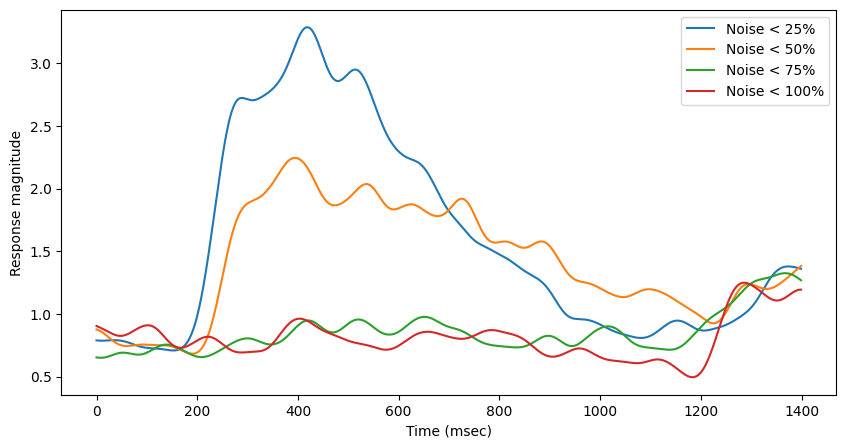

In [241]:
plt.figure(figsize=(10, 5))
plt.plot(V_ephocs_faces_noise_25.mean(0)[:, 46],label='Noise < 25%')
plt.plot(V_ephocs_faces_noise_50.mean(0)[:, 46],label='Noise < 50%')
plt.plot(V_ephocs_faces_noise_75.mean(0)[:, 46],label='Noise < 75%')
plt.plot(V_ephocs_faces_noise_100.mean(0)[:, 46],label='Noise < 100%')
plt.legend()
plt.xlabel('Time (msec)')
plt.ylabel('Response magnitude')

In [220]:
def noise_face_selectivity_index(V_ephocs_faces,V_ephocs_house,ch_id):

  return max(V_ephocs_faces.mean(0)[:, 46])/max(V_ephocs_house.mean(0)[:, 46])

selectivity_indices=[noise_face_selectivity_index(V_ephocs_faces_noise_25,V_ephocs_house_noise_25,46), noise_face_selectivity_index(V_ephocs_faces_noise_50,V_ephocs_house_noise_50,46), noise_face_selectivity_index(V_ephocs_faces_noise_75,V_ephocs_house_noise_75,46), noise_face_selectivity_index(V_ephocs_faces_noise_100,V_ephocs_house_noise_100,46)]


Text(0, 0.5, 'Face selectivity')

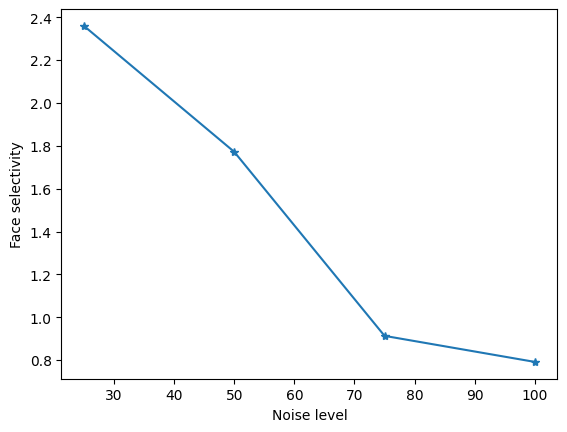

In [226]:
plt.plot([25,50,75,100],selectivity_indices,'-*')
plt.xlabel('Noise level')
plt.ylabel('Face selectivity')